<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/IntroCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales - CNN

Proceso de convolución en imágenes

[CNN](https://towardsdatascience.com/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9)




## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Un par de funciones de utilidad para trazar imágenes en escala de grises y RGB:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Implementación con TensorFlow

En **TensorFlow**, cada imagen de entrada se representa típicamente **como un tensor 3D** de forma [altura, ancho, canales]. 
- Un mini lote se representa como un tensor de forma 4D [tamaño del mini lote, altura, ancho, canales]. 
- Los pesos de una capa convolucional se representan como un tensor de forma 4D [$f_h, f_w, f_{n'}, f_n$]. 
- Los términos de sesgo de una capa convolucional se representan simplemente como un tensor de forma 1D [$f_n$].

**Ejemplo:**
1. Cargamos dos imágenes de muestra, utilizando *load_sample_images()* de Scikit-Learn (que carga dos imágenes en color, una de un templo chino y la otra de una flor). 
2. Las intensidades de píxeles (para cada canal de color) se representan como un byte de 0 a 255, por lo que escalamos estas características simplemente dividiendo por 255, para obtener flotantes que van de 0 a 1. 
3. Luego creamos dos filtros 7 × 7 (uno con una línea blanca vertical en el medio y la otra con una línea blanca horizontal en el medio), y las aplicamos a ambas imágenes usando la función *tf.nn.conv2d()*. 
4. En este ejemplo, usamos zero padding (*padding = "SAME"*) y un stride de 2. 
5. Finalmente, trazamos uno de los feature maps resultantes.

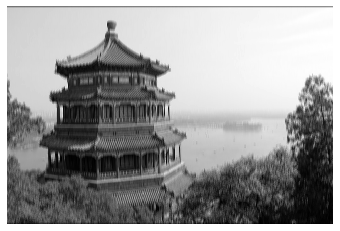

In [0]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

La línea *tf.nn.conv2d()* merece un poco de explicación:

- 'images' es el mini-lote de entrada (un tensor 4D, como se explicó anteriormente).
- 'filters' es el conjunto de filtros a aplicar (también un tensor 4D, como se explicó anteriormente).
- 'strides' es igual a 1, pero también podría ser una matriz 1D con 4 elementos, donde los dos elementos centrales son los pasos verticales y horizontales ($s_h$ y $s_w$). El primer y el último elemento deben ser actualmente iguales a 1. 
- El padding debe ser "*VALID*" o "*SAME*":
    - Si se establece en "*VALID*", la capa convolucional no usa relleno de cero y puede ignorar algunas filas y columnas en la parte inferior y derecha de la imagen de entrada, según el paso.
    - Si se establece en "*SAME*", la capa convolucional usa cero relleno si es necesario. En este caso, el número de neuronas de salida es igual al número de neuronas de entrada dividido por el paso, redondeado hacia arriba (en este ejemplo, 13/5 = 2.6, redondeado hasta 3). Luego se agregan ceros de la manera más uniforme posible alrededor de las entradas.
![cnn_padding.png](attachment:cnn_padding.png)

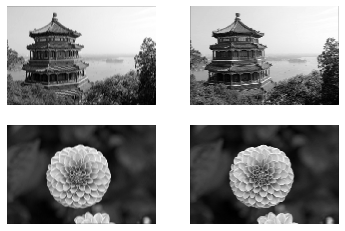

In [0]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [0]:
def crop(images):
    return images[150:220, 130:250]

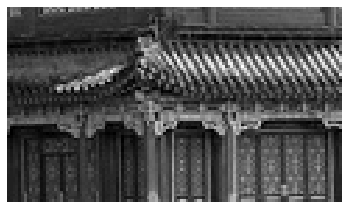

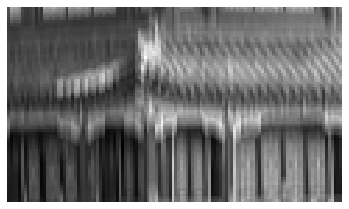

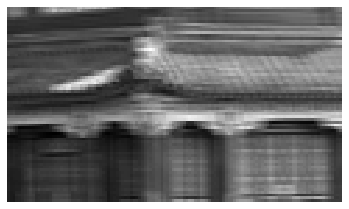

In [0]:
plot_image(crop(images[0, :, :, 0]))
#save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    #save_fig(filename, tight_layout=False)
    plt.show()

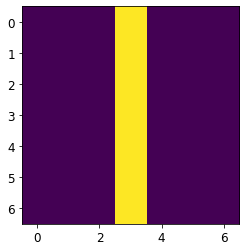

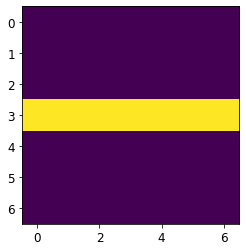

In [0]:
plt.imshow(filters[:, :, 0, 0])
plt.show()
plt.imshow(filters[:, :, 0, 1])
plt.show()

## Capa convolucional

En este ejemplo, **definimos manualmente los filtros**, pero en una CNN real normalmente definiría los **filtros como variables entrenables**, de modo que la red neuronal pueda aprender los filtros que funcionan mejor, como se explicó anteriormente. 
- Sin embargo, en lugar de crear manualmente las variables, simplemente puede usar la capa *keras.layers.Conv2D*:

In [0]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

Este código crea una capa Conv2D con 32 filtros, cada uno de $3\times 3$, usando un stride de 1 (tanto horizontal como verticalmente), el padding "SAME", y aplicando la función de activación **ReLU** a sus salidas. 

- Como puede ver, las capas convolucionales tienen bastantes hiperparámetros: debe elegir el número de filtros, su altura y ancho, los pasos y el tipo de relleno. Como siempre, **puede usar la validación cruzada para encontrar los valores correctos de hiperparámetro, pero esto lleva mucho tiempo**. 

## Capa de pooling

Implementar una capa de **max-pooling** en TensorFlow es bastante fácil. 
- El siguiente código crea una capa de max-pooling utilizando un núcleo $2\times 2$. 
- Los strides predeterminados para el tamaño del kernel, por lo que esta capa utilizará un stride de 2 (tanto horizontal como verticalmente). 
- Por defecto, utiliza padding "VALID" (es decir, sin relleno).

In [0]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [0]:
cropped_images = np.array([crop(image) for image in images])
output         = max_pool(cropped_images)

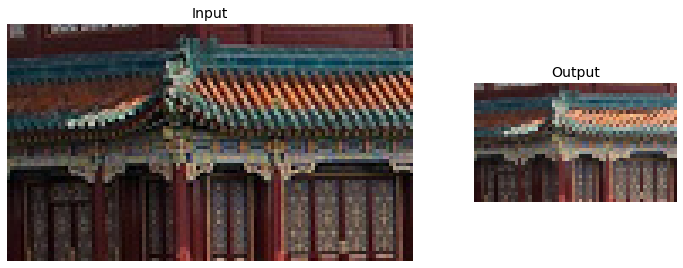

In [0]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
#save_fig("china_max_pooling")
plt.show()

### Average pooling

In [0]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [0]:
output_avg = avg_pool(cropped_images)

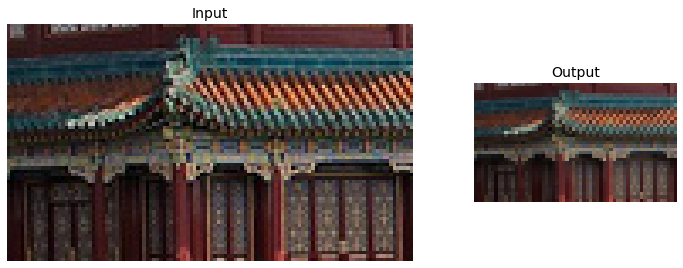

In [0]:
fig = plt.figure(figsize=(12, 8))
gs  = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Arquitectura CNN

Así es como puede implementar una CNN simple para abordar el conjunto de datos Fashion MNIST:

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean  = X_train.mean(axis=0, keepdims=True)
X_std   = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test  = (X_test - X_mean) / X_std
print(X_train.shape)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test  = X_test[..., np.newaxis]
print(X_train.shape)

(55000, 28, 28)
(55000, 28, 28, 1)


In [0]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, 
                  input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

- En este código, comenzamos usando la función *parcial()* para definir la clase **Conv2D**, llamada *DefaultConv2D*: **simplemente evita tener que repetir los mismos valores de hiperparámetro una y otra vez**.

- La primera capa usa un tamaño de kernel grande, pero sin strides porque las imágenes de entrada no son muy grandes. También establece input_shape = [28, 28, 1], lo que significa que las imágenes son $28\times 28$ píxeles, con un solo canal de color (es decir, **escala de grises**).

- A continuación, tenemos una capa de *max-pooling*, que divide cada dimensión espacial por un factor de dos (ya que *pool_size = 2*).

- Luego repetimos la misma estructura dos veces: dos capas convolucionales seguidas de una capa de agrupación máxima.

- Tenga en cuenta que la cantidad de filtros aumenta a medida que subimos la CNN hacia la capa de salida (inicialmente es 64, luego 128, luego 256): tiene sentido que crezca, ya que la cantidad de características de bajo nivel a menudo es bastante bajo (p. ej., círculos pequeños, líneas horizontales, etc.), pero hay muchas formas diferentes de combinarlos en funciones de nivel superior. 

- Luego está la red totalmente conectada (Fully-connected), compuesta de 2 capas densas ocultas y una capa de salida densa. Tenga en cuenta que **debemos aplanar sus entradas**, ya que una red densa espera una matriz 1D de características para cada instancia. También agregamos dos capas de *dropout*, con una tasa de dropout del $50\%$ cada una, para reducir el sobreajuste.

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score   = model.evaluate(X_test, y_test)
X_new   = X_test[:10] # pretend we have new images
y_pred  = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 187s 3ms/sample - loss: 0.7170 - accuracy: 0.7518 - val_loss: 0.3895 - val_accuracy: 0.8622
Epoch 2/10
55000/55000 [==============================] - 185s 3ms/sample - loss: 0.4240 - accuracy: 0.8573 - val_loss: 0.3358 - val_accuracy: 0.8794
Epoch 3/10
55000/55000 [==============================] - 186s 3ms/sample - loss: 0.3654 - accuracy: 0.8766 - val_loss: 0.2967 - val_accuracy: 0.8922
Epoch 4/10
55000/55000 [==============================] - 198s 4ms/sample - loss: 0.3317 - accuracy: 0.8880 - val_loss: 0.3263 - val_accuracy: 0.8898
Epoch 5/10
55000/55000 [==============================] - 189s 3ms/sample - loss: 0.3041 - accuracy: 0.8956 - val_loss: 0.3168 - val_accuracy: 0.8920
Epoch 6/10
55000/55000 [==============================] - 180s 3ms/sample - loss: 0.2960 - accuracy: 0.8991 - val_loss: 0.2975 - val_accuracy: 0.8934
Epoch 7/10
55000/55000 [===========================